In [11]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras.datasets import mnist
from kerastuner.tuners import RandomSearch

In [12]:
# Loading the MNIST dataset in Keras
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1) / 255.0
test_images = test_images.reshape(-1, 28, 28, 1) / 255.0

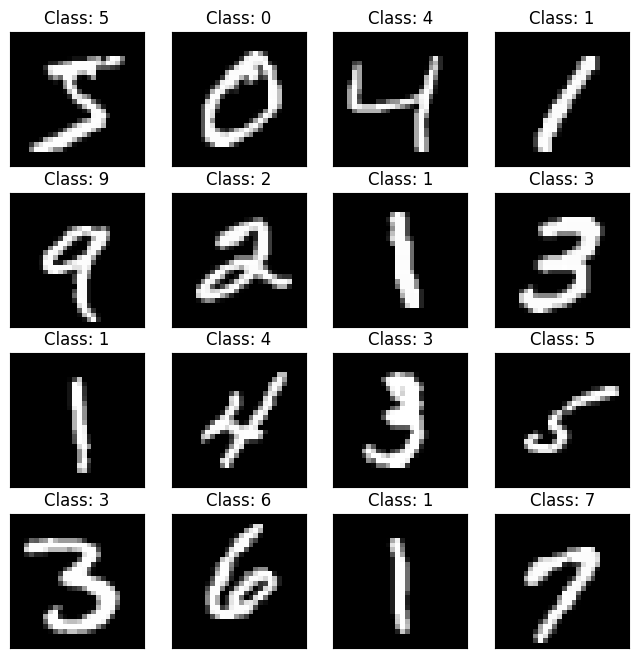

In [44]:
# Displaying the first 16 images of the dataset with their labels
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([]) 
    ax.set_title(f'Class: {train_labels[i]}') 
plt.show()

In [14]:
# Hyperparameter tuning with Keras Tuner
def CNN(hp):
    model = Sequential()

    num_filters = hp.Choice('num_filters', values=[4, 8, 16, 32]) 
    conv_kernel_size = hp.Choice('conv_kernel_size', values=[3, 5]) 
    pool_kernel_size = hp.Choice('pool_kernel_size', values=[2, 4]) 
    dense_nodes = hp.Choice('dense_nodes', values=[64, 128, 256])

    model.add(Conv2D(num_filters, (conv_kernel_size, conv_kernel_size), input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_kernel_size, pool_kernel_size)))

    model.add(Conv2D(num_filters * 2, (conv_kernel_size, conv_kernel_size)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_kernel_size, pool_kernel_size)))

    model.add(Flatten())
    model.add(Dense(dense_nodes))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # Add learning rate, batch size, and epochs as hyperparameters
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    epochs = hp.Choice('epochs', values=[5, 10, 15])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    CNN,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='hyperparameter_tuning', 
    overwrite=True,
    project_name='cnn_tuning'
)

tuner.search(train_images, train_labels, validation_split=0.2)  

# Get the best model found by KerasTuner
best_model = tuner.get_best_models(num_models=1)[0]
tuner.save()
best_model.save('./models/best_model_No_MC.h5', overwrite=True) 

Trial 5 Complete [00h 01m 04s]
val_accuracy: 0.9517916440963745

Best val_accuracy So Far: 0.9747500121593475
Total elapsed time: 00h 04m 21s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_model = tf.keras.models.load_model('./models/best_model_No_MC.h5')
best_model.fit(train_images, train_labels)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.argmax(best_model.predict(test_images), axis=-1), test_labels)
print(f"Accuracy: {accuracy:.2%}")

313/313 [==============================] - 2s 7ms/step
Accuracy: 98.59%


In [15]:
tf.keras.backend.clear_session()

In [16]:
# MC Dropout 
# Create the MC dropout layer (i.e. a MC dropout layer that is active during both training and testing)
class MC_dropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    
def build_model(hp):
    model = Sequential()

    num_filters = hp.Choice('num_filters', values=[4, 8, 16, 32]) 
    conv_kernel_size = hp.Choice('conv_kernel_size', values=[3, 5]) 
    pool_kernel_size = hp.Choice('pool_kernel_size', values=[2, 4]) 
    dense_nodes = hp.Choice('dense_nodes', values=[64, 128, 256])

    model.add(Conv2D(num_filters, (conv_kernel_size, conv_kernel_size), input_shape=(28, 28, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_kernel_size, pool_kernel_size)))

    model.add(Conv2D(num_filters * 2, (conv_kernel_size, conv_kernel_size)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_kernel_size, pool_kernel_size)))

    model.add(Flatten())
    model.add(Dense(dense_nodes))
    model.add(Activation('relu'))
    model.add(MC_dropout(0.2))  # Apply dropout during training

    model.add(Dense(10))
    model.add(Activation('softmax'))

    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    epochs = hp.Choice('epochs', values=[5, 10, 15])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='hyperparameter_tuning_MC_dropout',
    overwrite=True,
    project_name='cnn_tuning'
) 

tuner.search(train_images, train_labels, validation_split=0.2, verbose=1)

# Get the best model found by KerasTuner
best_model = tuner.get_best_models(num_models=1)[0]
tuner.save()
best_model.save('./models/best_model_MC.h5', overwrite=True)

Trial 5 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.9545833468437195
Total elapsed time: 00h 04m 06s
INFO:tensorflow:Oracle triggered exit


In [41]:
best_model = tf.keras.models.load_model('./models/best_model_MC.h5', custom_objects={'MC_dropout': MC_dropout})
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(np.argmax(best_model.predict(test_images), axis=-1), test_labels)

print(f"Accuracy: {accuracy:.2%}")

313/313 [==============================] - 3s 9ms/step
Accuracy: 95.85%


1875/1875 [==============================] - 20s 11ms/step


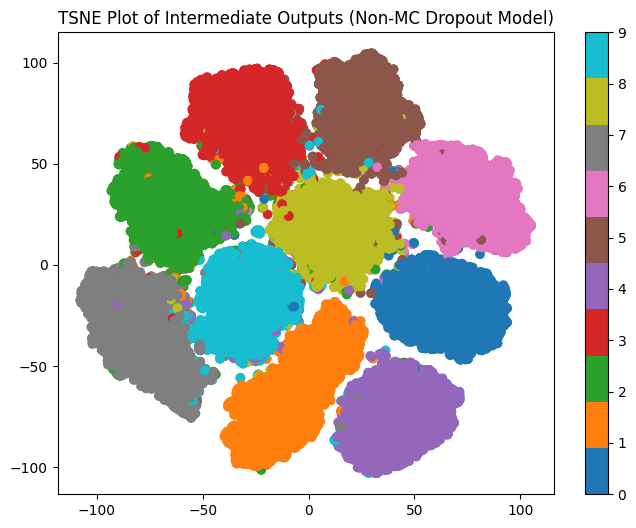

In [17]:
# TSNE Plot of the intermediate outputs of the best model without MC Dropout on the training data
from sklearn.manifold import TSNE

best_model = tf.keras.models.load_model('./models/best_model_No_MC.h5')
# Remove the final layer from the best model
best_model_without_final_layer = tf.keras.Model(
    inputs=best_model.inputs,
    outputs=best_model.layers[-2].output 
)

# Get the intermediate layer's outputs for the training data
intermediate_outputs = best_model_without_final_layer.predict(train_images)

# Perform TSNE on the intermediate outputs
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(intermediate_outputs)

# Plot the TSNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=train_labels, cmap='tab10')
plt.title('TSNE Plot of Intermediate Outputs (Non-MC Dropout Model)')
plt.colorbar()
plt.show()

313/313 [==============================] - 3s 10ms/step


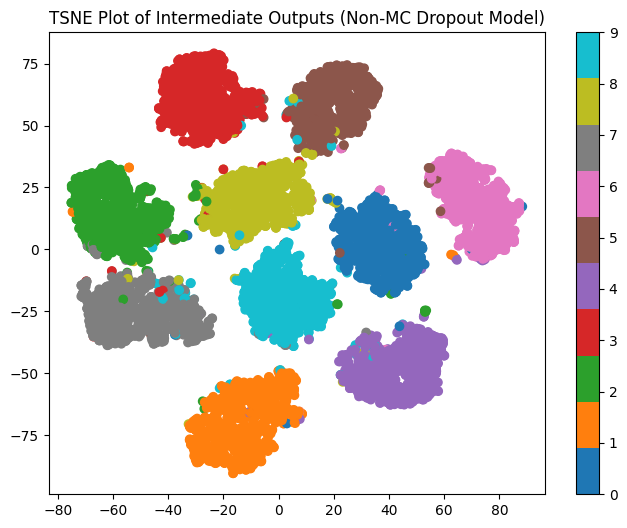

In [25]:
# TSNE Plot of Intermediate Outputs (Non-MC Dropout Model) on test data
from sklearn.manifold import TSNE

best_model = tf.keras.models.load_model('./models/best_model_No_MC.h5')
# Remove the final layer from the best model
best_model_without_final_layer = tf.keras.Model(
    inputs=best_model.inputs,
    outputs=best_model.layers[-2].output  # Remove the final layer
)

# Get the intermediate layer's outputs for the training data
intermediate_outputs = best_model_without_final_layer.predict(test_images)

# Perform TSNE on the intermediate outputs
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(intermediate_outputs)

# Plot the TSNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=test_labels, cmap='tab10')
plt.title('TSNE Plot of Intermediate Outputs (Non-MC Dropout Model)')
plt.colorbar()
plt.show()

In [56]:
# Prediction on FASHION MNIST dataset using MC Dropout on a new model
# MC Dropout 
# Create the MC dropout layer (i.e. a MC dropout layer that is active during both training and testing)
class MC_dropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    
def build_model(hp):
    model = Sequential()
    num_filters = 32
    conv_kernel_size = 3
    pool_kernel_size = 2
    dense_nodes = 512
    # num_filters = hp.Choice('num_filters', values=[4, 8, 16, 32]) 
    # conv_kernel_size = hp.Choice('conv_kernel_size', values=[3, 5]) 
    # pool_kernel_size = hp.Choice('pool_kernel_size', values=[2]) 
    # dense_nodes = hp.Choice('dense_nodes', values=[64, 128, 256])

    model.add(Conv2D(num_filters, (conv_kernel_size, conv_kernel_size), input_shape=(28, 28, 1), activation='relu'))
    # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_kernel_size, pool_kernel_size)))

    model.add(Conv2D(num_filters * 2, (conv_kernel_size, conv_kernel_size), activation='relu'))
    # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_kernel_size, pool_kernel_size)))

    model.add(Conv2D(num_filters * 4, (conv_kernel_size, conv_kernel_size), activation='relu'))
    # model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_kernel_size, pool_kernel_size)))

    model.add(Flatten())
    model.add(Dense(dense_nodes, activation='relu'))
    # model.add(Activation('relu'))
    # model.add(MC_dropout(0.2))  # Apply dropout during training
    model.add(Dense(dense_nodes // 2, activation='relu'))
    model.add(Dense(dense_nodes // 4, activation='relu'))
    # model.add(Activation('relu')) 
    # model.add(MC_dropout(0.2))  # Apply dropout during training

    model.add(Dense(10, activation='relu'))
    model.add(Activation('softmax'))

    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    epochs = hp.Choice('epochs', values=[5, 10, 15])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='hyperparameter_tuning_MC_dropout_FMNIST',
    overwrite=True,
    project_name='cnn_tuning'
) 

(fashion_train_x, fashion_train_y ), (fashion_test_x, fashion_test_y) = tf.keras.datasets.fashion_mnist.load_data()
fashion_train_x = fashion_train_x.reshape(-1, 28, 28, 1) / 255.0
fashion_test_x = fashion_test_x.reshape(-1, 28, 28, 1) / 255.0

tuner.search(fashion_train_x, fashion_train_y, validation_split=0.2, verbose=1)

# Get the best model found by KerasTuner
best_model = tuner.get_best_models(num_models=1)[0]
tuner.save()
best_model.save('./models/best_model_MC_FMNIST.h5', overwrite=True)

Trial 5 Complete [00h 02m 12s]
val_accuracy: 0.2772499993443489

Best val_accuracy So Far: 0.5680833458900452
Total elapsed time: 00h 12m 31s
INFO:tensorflow:Oracle triggered exit


313/313 [==============================] - 3s 9ms/step
Predictive Accuracy: 0.1000
313/313 [==============================] - 4s 12ms/step
Uncertainty in prediction: 0.0000


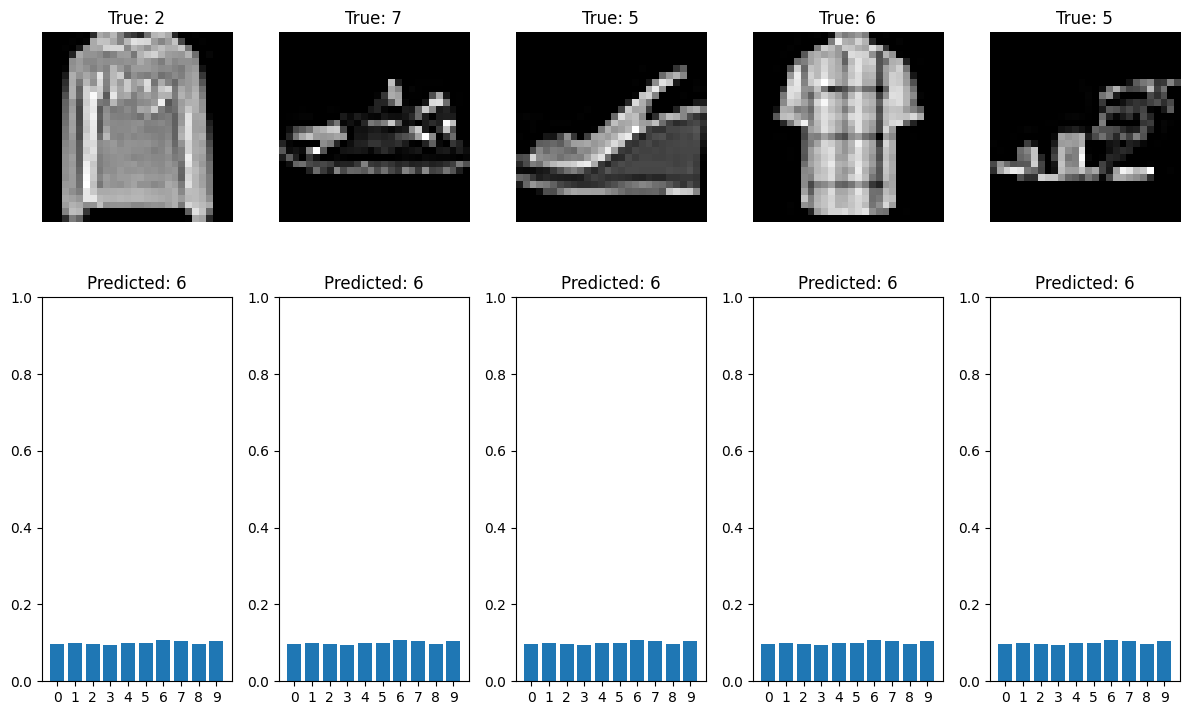

In [53]:
# Prediction on Fashion MNIST dataset using CNN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
saved_model_path = './models/best_model_MC_FMNIST.h5'
model = tf.keras.models.load_model(saved_model_path, custom_objects={'MC_dropout': MC_dropout})
(fashion_train_x, fashion_train_y ), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()

# Make predictions on the test data
model.fit(fashion_train_x, fashion_train_y)
predictions = model.predict(test_x)

# Calculate predictive accuracy
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == test_y)
print(f"Predictive Accuracy: {accuracy:.4f}")

# Assess uncertainty using MC Dropout by predicting multiple times on the same data
def mc_dropout_predict(model, x, n_samples=10):
    results = [model.predict(x) for _ in range(n_samples)]
    return np.array(results)

n_mc_samples = 50  # Number of MC samples for dropout
mc_dropout_predictions = mc_dropout_predict(model, test_x, n_samples=n_mc_samples)

# Calculate uncertainty as the standard deviation of predictions across MC samples
prediction_std = np.std(mc_dropout_predictions, axis=0)
print(f"Uncertainty in prediction: {np.mean(prediction_std):.4f}")

# Optionally, create visualizations to understand uncertainty
# For example, you can plot images along with their prediction uncertainty
num_images_to_visualize = 5
indices_to_visualize = np.random.choice(len(test_x), num_images_to_visualize, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.title(f"True: {test_y[idx]}")
    plt.axis('off')

    plt.subplot(2, num_images_to_visualize, i + num_images_to_visualize + 1)
    plt.bar(range(10), predictions[idx], yerr=prediction_std[idx])
    plt.xticks(range(10))
    plt.title(f"Predicted: {predicted_labels[idx]}")
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

313/313 [==============================] - 4s 13ms/step
Predictive Accuracy: 0.1271
313/313 [==============================] - 5s 17ms/step


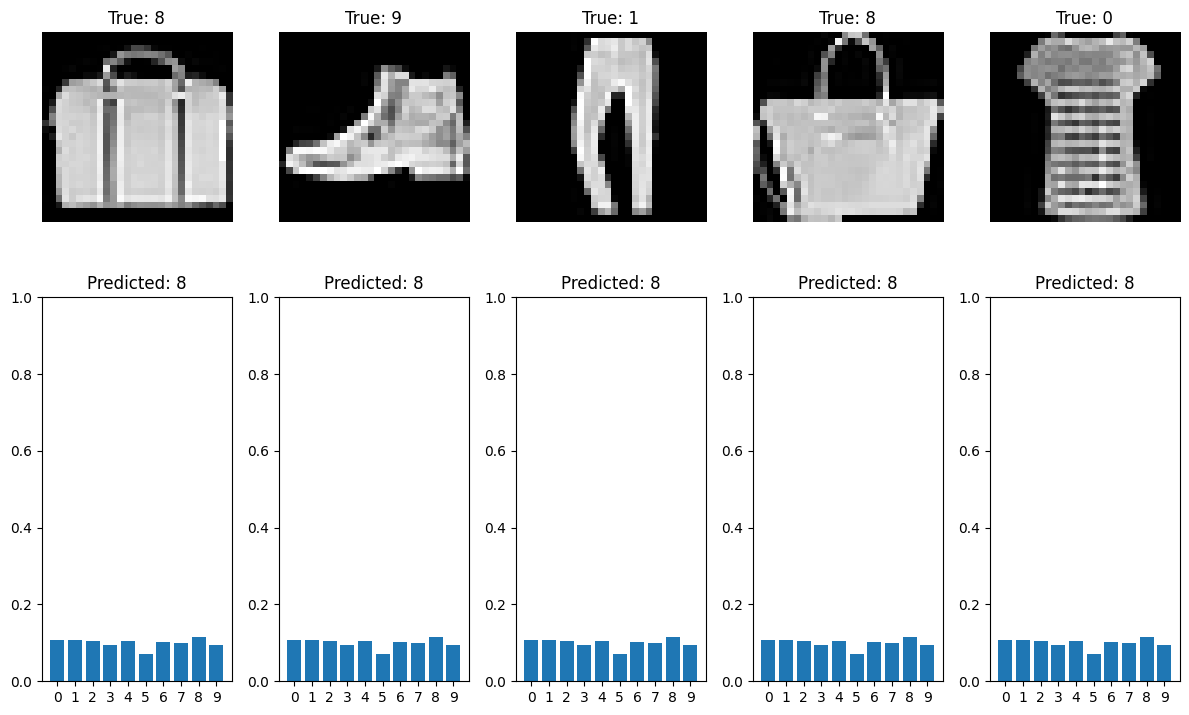

In [24]:
# Prediction on Fashion MNIST dataset using CNN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
saved_model_path = './models/best_model_MC.h5'
model = tf.keras.models.load_model(saved_model_path, custom_objects={'MC_dropout': MC_dropout})
(fashion_train_x, fashion_train_y ), (fashion_test_x, fashion_test_y) = tf.keras.datasets.fashion_mnist.load_data()
fashion_train_x = fashion_train_x.reshape(-1, 28, 28, 1) / 255.0
fashion_test_x = fashion_test_x.reshape(-1, 28, 28, 1) / 255.0

# Make predictions on the test data
model.fit(fashion_train_x, fashion_train_y)
predictions = model.predict(fashion_test_x)

# Calculate predictive accuracy
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == fashion_test_y)
print(f"Predictive Accuracy: {accuracy:.4f}")

# Assess uncertainty using MC Dropout by predicting multiple times on the same data
def mc_dropout_predict(model, x, n_samples=10):
    results = [model.predict(x) for _ in range(n_samples)]
    return np.array(results)

n_mc_samples = 50  # Number of MC samples for dropout
mc_dropout_predictions = mc_dropout_predict(model, fashion_test_x, n_samples=n_mc_samples)

# Calculate uncertainty as the standard deviation of predictions across MC samples
prediction_std = np.std(mc_dropout_predictions, axis=0)
print(f"Uncertainty in prediction: {np.mean(prediction_std):.4f}")

# Optionally, create visualizations to understand uncertainty
# For example, you can plot images along with their prediction uncertainty
num_images_to_visualize = 5
indices_to_visualize = np.random.choice(len(fashion_test_x), num_images_to_visualize, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(fashion_test_x[idx], cmap='gray')
    plt.title(f"True: {fashion_test_y[idx]}")
    plt.axis('off')

    plt.subplot(2, num_images_to_visualize, i + num_images_to_visualize + 1)
    plt.bar(range(10), predictions[idx], yerr=prediction_std[idx])
    plt.xticks(range(10))
    plt.title(f"Predicted: {predicted_labels[idx]}")
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()


625/625 [==============================] - 6s 10ms/step


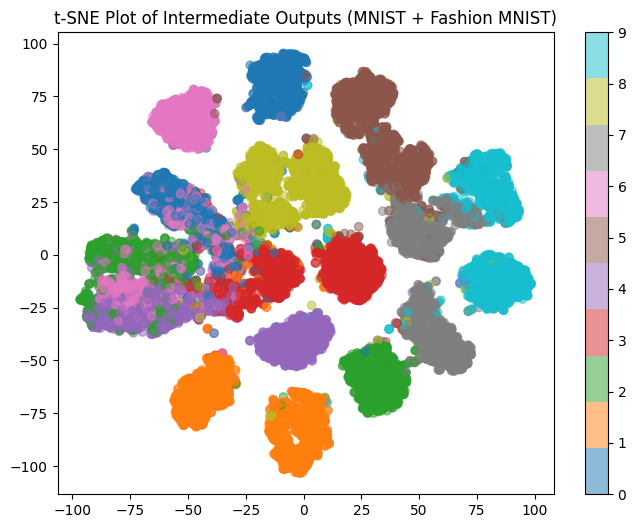

In [48]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the saved model
saved_model_path = './models/best_model_No_MC.h5'
model = load_model(saved_model_path)

# Load MNIST and Fashion MNIST datasets
mnist_data = tf.keras.datasets.mnist.load_data()
fashion_data = tf.keras.datasets.fashion_mnist.load_data()

# Combine the MNIST and Fashion MNIST data and labels
combined_train_x = np.concatenate([mnist_data[0][0], fashion_data[0][0]], axis=0)
combined_train_y = np.concatenate([mnist_data[0][1], fashion_data[0][1]], axis=0)

combined_test_x = np.concatenate([mnist_data[1][0], fashion_data[1][0]], axis=0)
combined_test_y = np.concatenate([mnist_data[1][1], fashion_data[1][1]], axis=0)

# Preprocess the data (assuming the model expects input shape (28, 28, 1))
combined_train_x = combined_train_x.reshape(-1, 28, 28, 1) / 255.0
combined_test_x = combined_test_x.reshape(-1, 28, 28, 1) / 255.0
model.fit(combined_train_x, combined_train_y)

# Get the intermediate layer's outputs for the training data
intermediate_outputs = model.predict(combined_test_x)

# Get the intermediate layer's outputs for the combined dataset
intermediate_outputs = model.layers[-2].output  # Remove the final layer
get_intermediate_outputs = tf.keras.backend.function([model.input], [intermediate_outputs])
intermediate_outputs = get_intermediate_outputs(combined_test_x)[0]

# Perform t-SNE on the intermediate outputs
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(intermediate_outputs)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=combined_test_y, cmap='tab10', alpha=0.5)
plt.title('t-SNE Plot of Intermediate Outputs (MNIST + Fashion MNIST)')
plt.colorbar()
plt.show()


[[ 58.974575  -38.27312  ]
 [ 27.583508  -68.10496  ]
 [  4.2378955 -87.02431  ]
 ...
 [-11.429087   38.9719   ]
 [-46.049603  -63.352978 ]
 [ 40.87829    30.19531  ]]
(20000, 2)


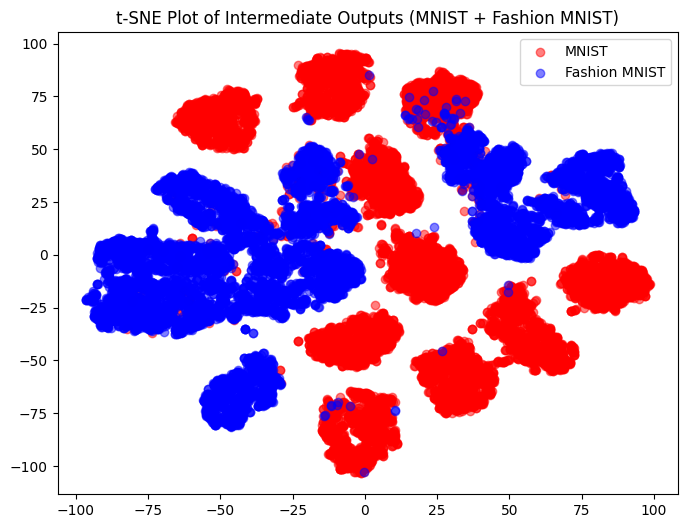

In [49]:
# Color-code the t-SNE plot to distinguish between MNIST and Fashion MNIST points
print(tsne_results)
print(tsne_results.shape)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[0:10000, 0], tsne_results[0:10000, 1], c='red', label='MNIST', alpha=0.5)
plt.scatter(tsne_results[10000: , 0], tsne_results[10000:, 1], c='blue', label='Fashion MNIST', alpha=0.5)
plt.title('t-SNE Plot of Intermediate Outputs (MNIST + Fashion MNIST)')
plt.legend()
plt.show()